## Project - Part II


In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Literal
from sklearn.cluster import KMeans
from utils.flow_simulation import (
    simulate_flow,
    plot_particle_simulation
)
from utils.gaussian_process import (
    optimize_kernel_params,
    plot_grid_search_results,
    predict_conditional_mean_and_var,
    radial_basis_kernel,
    rational_quadratic_kernel,
    add_intermediate_points
)


### Data Loading

Make sure to download the OceanFlow data from the course's website and place it in the `data` folder.


In [2]:
# Time steps in the simulation
n_steps = 100

# Speed flow: 3D array with shape (Time, X coordinates, Y coordinates, 2)
speed_flow = []

# Load the X and Y data for each time step
for i in range(n_steps):

    # Load the data for X and Y
    # The data is given in a matrix with data for each position in the grid
    Vx = pd.read_csv(f'./data/OceanFlow/{i+1}u.csv', header=None).values
    Vy = pd.read_csv(f'./data/OceanFlow/{i+1}v.csv', header=None).values

    # Construct the total velocity by concatenating the X and Y components as
    # columns in a single array
    V = np.stack([Vx, Vy], axis=2)

    # Add the current time step velocity to the speed_flow array
    speed_flow.append(V)

# Convert the speed_flow list to a numpy array
Vt = np.array(speed_flow)
print("Data Shape:", Vt.shape)
print("- Timesteps:", Vt.shape[0])
print("- Y coordinates:", Vt.shape[1])
print("- X coordinates:", Vt.shape[2])
print("- Velocity components:", Vt.shape[3])

# Get the X and Y velocities
Vx = Vt[:, :, :, 0]
Vy = Vt[:, :, :, 1]

# Load the mask data
mask = pd.read_csv('./data/OceanFlow/mask.csv', header=None).values

# The mask is flipped in the Y axis, so we flip it back
mask = np.flip(mask, axis=0)


Data Shape: (100, 504, 555, 2)
- Timesteps: 100
- Y coordinates: 504
- X coordinates: 555
- Velocity components: 2


### Part II


#### General Parameters


In [3]:
# =============== GENERAL PARAMS =============== #

# Folds to use for cross validation
num_folds = 20

# Folder where images will be saved
images_folder = "./Images/"

# Selected position for which to predict the velocity
selected_position = np.array([400, 200])

# Method used to predict the initial mean of the Gaussian Process
initial_mean_method: Literal["moving_average", "mean", "zero"] = "zero"

# =================== KERNEL =================== #

kernel_option: Literal["rbf", "rq"] = "rbf"

if kernel_option == "rbf":

    # Prefix for the images
    images_prefix = "rbf"

    # Kernel to use for the Gaussian Process
    selected_kernel = radial_basis_kernel

    # Create a range of values for the kernel parameters
    param_ranges = {
        "l": np.linspace(0.1, 5, 18),
        "sigma": np.linspace(0.1, 2, 5),
    }

    # Parameters to plot in the grid search plot
    plot_params = ["l", "sigma"]

elif kernel_option == "rq":

    # Prefix for the images
    images_prefix = "rq"

    # Kernel to use for the Gaussian Process
    # selected_kernel = radial_basis_kernel
    selected_kernel = rational_quadratic_kernel

    # Create a range of values for the kernel parameters
    param_ranges = {
        "l": np.linspace(0.1, 5, 18),
        "sigma": np.linspace(0.1, 2, 5),
        "alpha": np.linspace(0.5, 3, 6),
    }

    # Parameters to plot in the grid search plot
    plot_params = ["l", "alpha"]

else:
    raise ValueError("Invalid kernel test")


#### Problem 4.a (10 points)

Take into consideration that now measurements are considered to have 3 days between them, instead of the 3 hours used in the previous part.


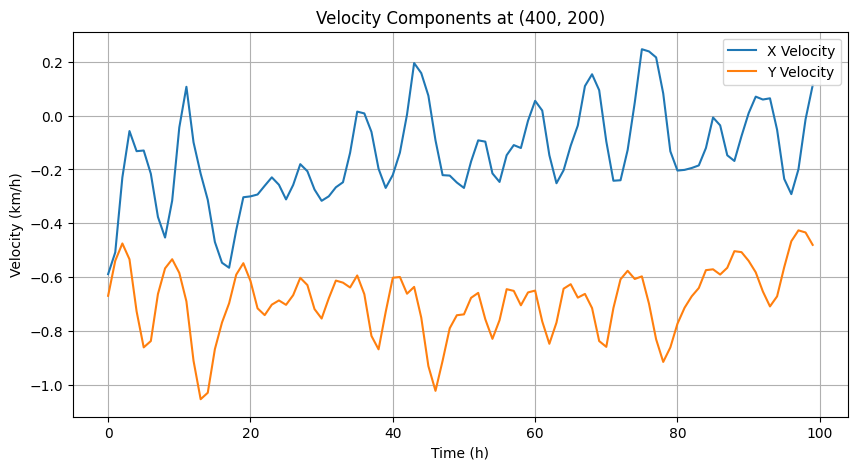

In [4]:
# Select a specific location to get the velocity data
x = selected_position[0]
y = selected_position[1]

# Get the velocity data for the selected location (Vl = Location Velocity)
V_loc = Vt[:, y, x, :]

# Get the X and Y velocity components
Vx_loc = V_loc[:, 0]
Vy_loc = V_loc[:, 1]

# ==================== PLOT ==================== #

# Plot the X and Y velocity components
plt.figure(figsize=(10, 5))
plt.plot(Vx_loc, label='X Velocity')
plt.plot(Vy_loc, label='Y Velocity')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Velocity (km/h)')
plt.title(f'Velocity Components at ({x}, {y})')
plt.grid()

# Save the plot
plt.savefig(f'{images_folder}{images_prefix}_selected_location_velocities.png')

plt.show()


General parameters of the entire problem


In [5]:
# ================ OPTIMIZATION ================ #

# Optimize the kernel parameters for the X component
optimal_params_x, x_results_df = optimize_kernel_params(
    data=Vx_loc,
    param_ranges=param_ranges,
    num_folds=num_folds,
    mean_prediction_method=initial_mean_method,
    kernel=selected_kernel
)

# Optimize the kernel parameters for the Y component
optimal_params_y, y_results_df = optimize_kernel_params(
    data=Vy_loc,
    param_ranges=param_ranges,
    num_folds=num_folds,
    mean_prediction_method=initial_mean_method,
    kernel=selected_kernel
)


100%|██████████| 90/90 [00:07<00:00, 11.62it/s]



X Velocity (Vx)
- Optimal 'l': 2.11764705882353
- Optimal 'sigma': 0.1

Y Velocity (Vy)
- Optimal 'l': 2.11764705882353
- Optimal 'sigma': 0.1


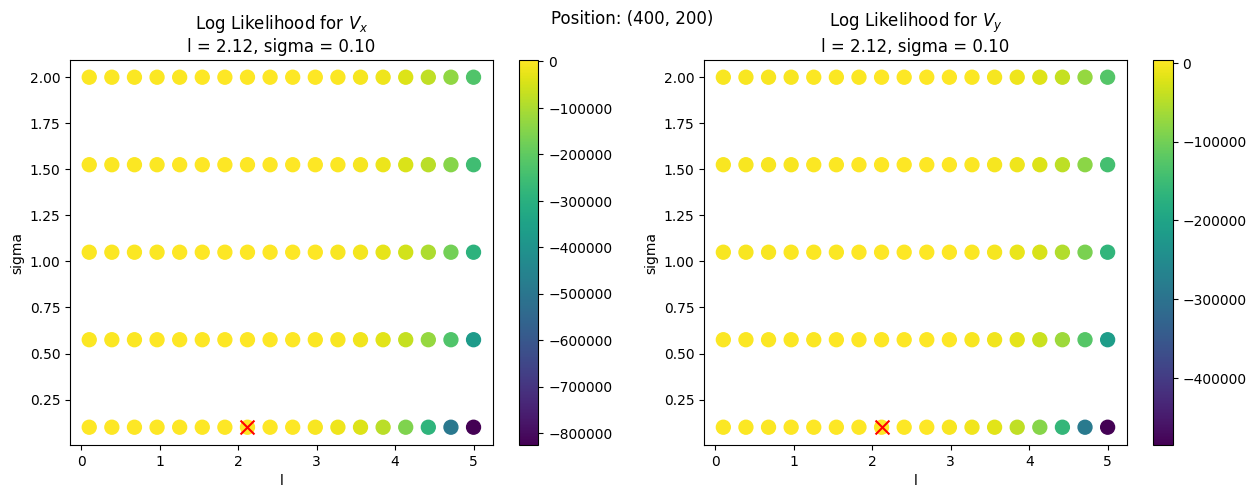

In [6]:
# =================== RESULTS ================== #

print()
print("X Velocity (Vx)")
for param, value in optimal_params_x.items():
    print(f"- Optimal '{param}': {value}")

print()
print("Y Velocity (Vy)")
for param, value in optimal_params_y.items():
    print(f"- Optimal '{param}': {value}")

# ==================== PLOT ==================== #

# Plot the results of the grid search
plot_grid_search_results(
    x_results_df=x_results_df,
    y_results_df=y_results_df,
    position=selected_position,
    params_to_plot=plot_params,
    save_to_file=True,
    filename=f'{images_folder}{images_prefix}_grid_search_results_selected_pos.png'
)


#### Zooming into the Search Space


In [5]:
# Create a new range of values for the zoomed in grid search
if kernel_option == "rbf":
    param_ranges_zoom = {
        "l": np.linspace(1, 3, 25),
        "sigma": np.linspace(0.1, 1, 10),
    }

elif kernel_option == "rq":
    param_ranges_zoom = {
        "l": np.linspace(2, 5, 25),
        "sigma": np.linspace(0.01, 0.5, 10),
        "alpha": np.linspace(0.1, 1, 10),
    }

else:
    raise ValueError(f"Invalid kernel test: {kernel_option}")

# ================ OPTIMIZATION ================ #

# Optimize the kernel parameters for the X component
optimal_params_x, x_results_df = optimize_kernel_params(
    data=Vx_loc,
    param_ranges=param_ranges_zoom,
    num_folds=num_folds,
    kernel=selected_kernel,
    mean_prediction_method=initial_mean_method
)

# Optimize the kernel parameters for the Y component
optimal_params_y, y_results_df = optimize_kernel_params(
    data=Vy_loc,
    param_ranges=param_ranges_zoom,
    num_folds=num_folds,
    kernel=selected_kernel,
    mean_prediction_method=initial_mean_method
)


100%|██████████| 250/250 [00:20<00:00, 12.49it/s]



X Velocity (Vx)
- Optimal 'l': 2.0
- Optimal 'sigma': 0.1

Y Velocity (Vy)
- Optimal 'l': 2.1666666666666665
- Optimal 'sigma': 0.1


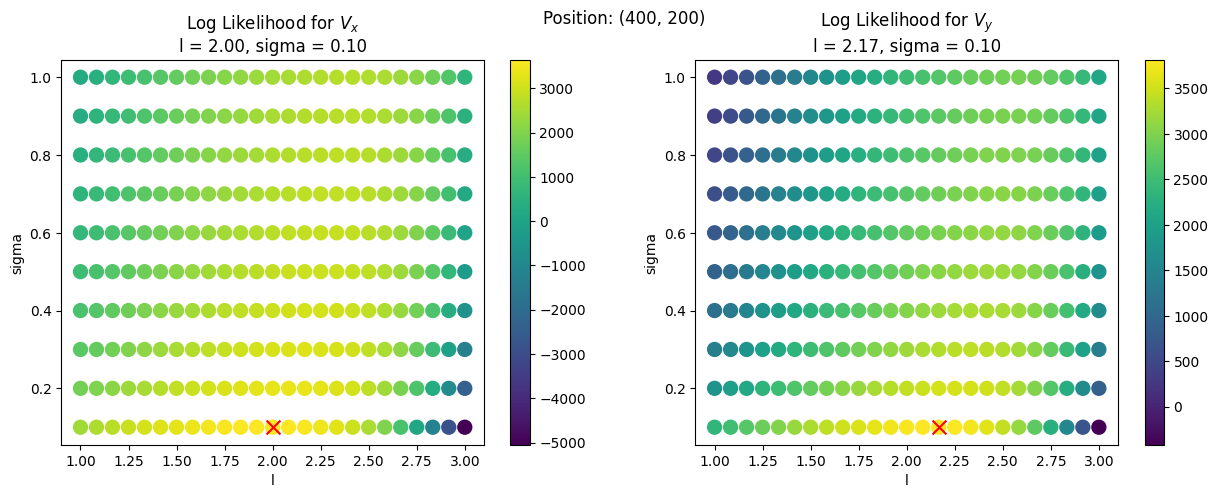

In [6]:
# =================== RESULTS ================== #

print()
print("X Velocity (Vx)")
for param, value in optimal_params_x.items():
    print(f"- Optimal '{param}': {value}")

print()
print("Y Velocity (Vy)")
for param, value in optimal_params_y.items():
    print(f"- Optimal '{param}': {value}")

# ==================== PLOT ==================== #

# Plot the results of the grid search
plot_grid_search_results(
    x_results_df=x_results_df,
    y_results_df=y_results_df,
    position=selected_position,
    params_to_plot=plot_params,
    save_to_file=True,
    filename=f'{images_folder}{images_prefix}_grid_search_results_selected_pos_zoom.png'
)


#### Problem 4.b (5 points)


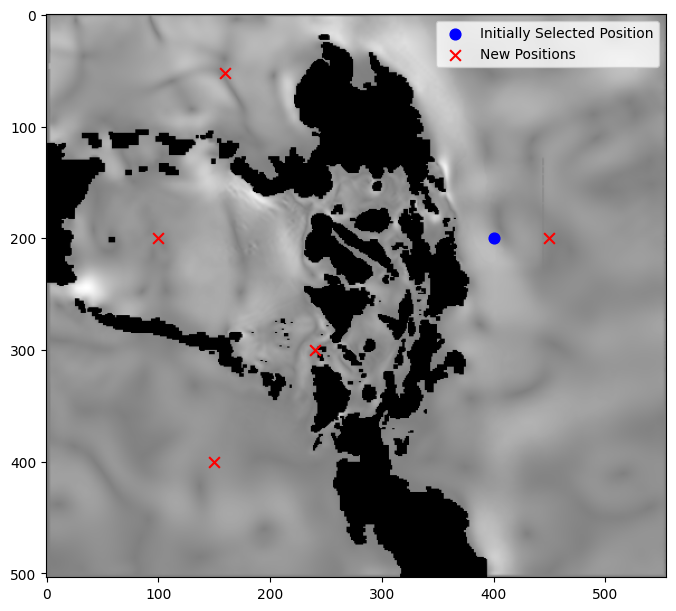

In [9]:
# Different positions to test for the prediction
positions = np.array([
    [150, 400],
    [240, 300],
    [450, 200],
    [160, 52],
    [100, 200]
])

# Get all of the X and Y components
Vx = Vt[:, :, :, 0]
Vy = Vt[:, :, :, 1]

# Calculate the speed
final_speed = np.sqrt(Vx**2 + Vy**2)

# Plot the mask and the speed
plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap='gray')
plt.imshow(final_speed[0], cmap='gray', alpha=0.5)

# Plot the initial selected position and the new ones
plt.scatter(
    selected_position[0],
    selected_position[1],
    c='b',
    s=60,
    marker='o',
    label="Initially Selected Position"
)
plt.scatter(
    positions[:, 0],
    positions[:, 1],
    c='r',
    s=60,
    marker='x',
    label="New Positions"
)
plt.legend()

# Save the plot
plt.savefig(
    f'{images_folder}{images_prefix}_selected_position_and_new_positions.png'
)
plt.show()


100%|██████████| 90/90 [00:10<00:00,  8.48it/s]


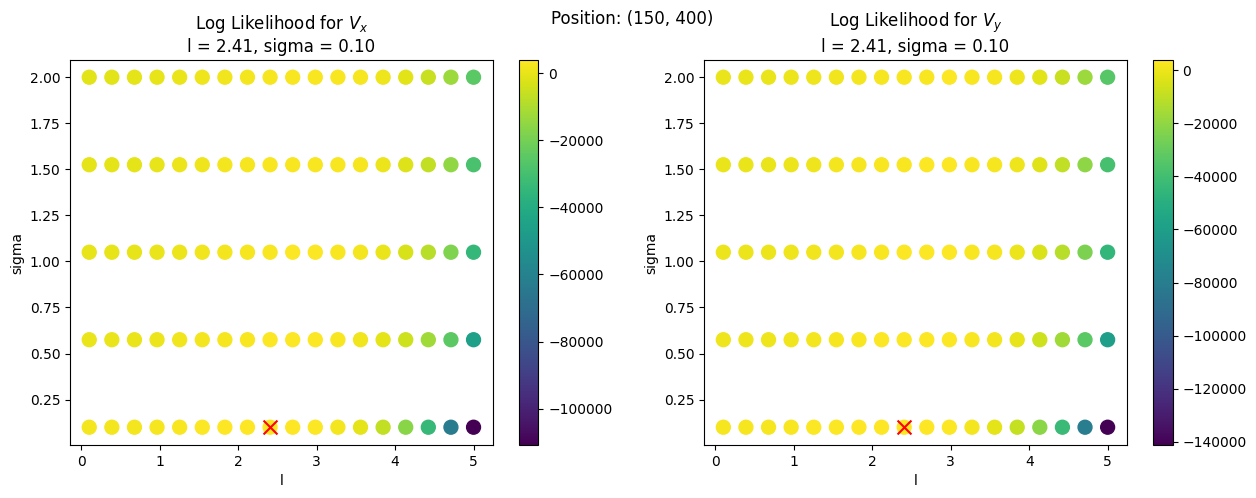

100%|██████████| 90/90 [00:10<00:00,  8.46it/s]


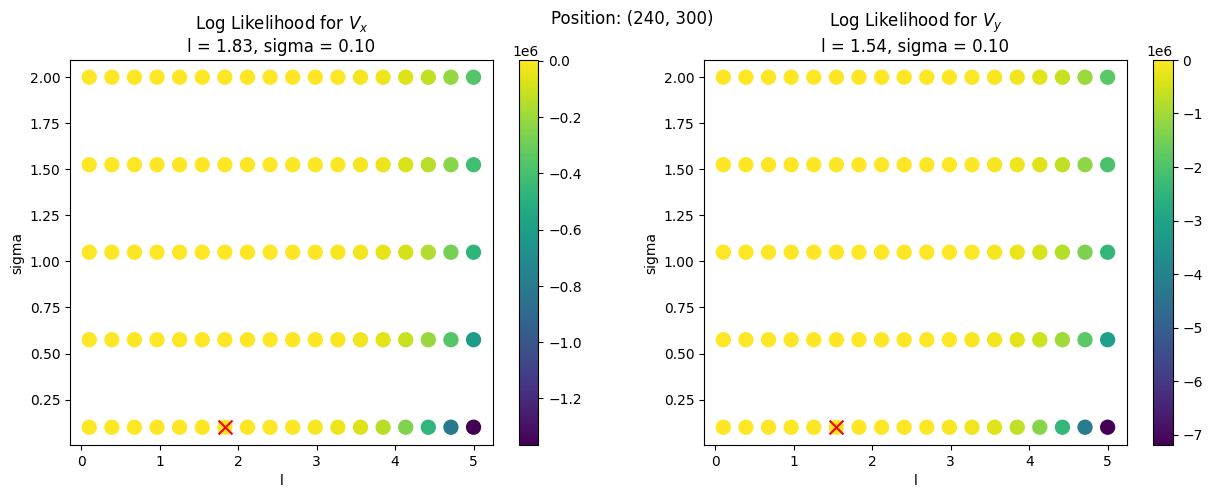

100%|██████████| 90/90 [00:10<00:00,  8.45it/s]


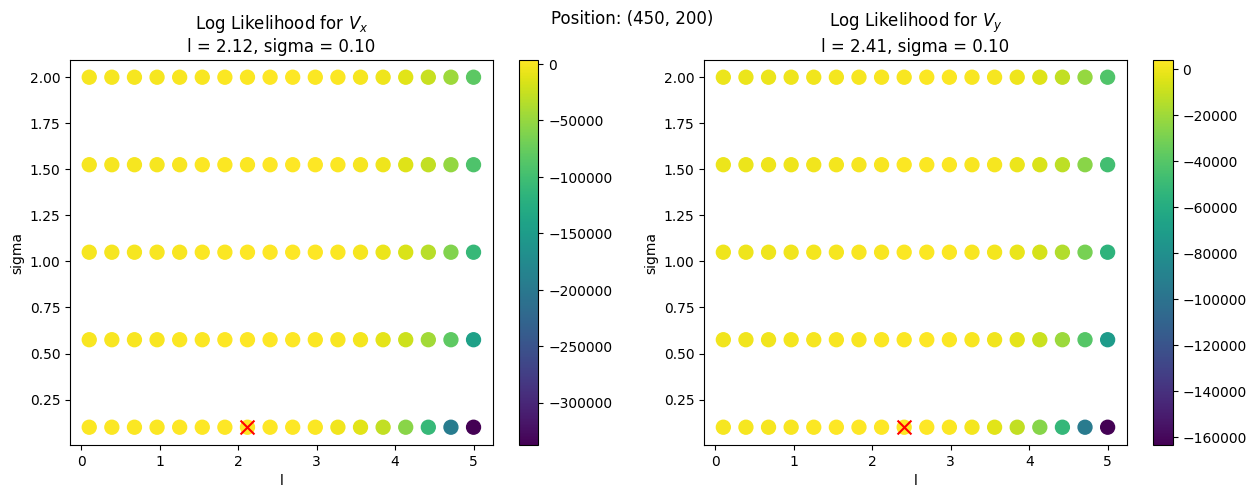

100%|██████████| 90/90 [00:11<00:00,  7.99it/s]


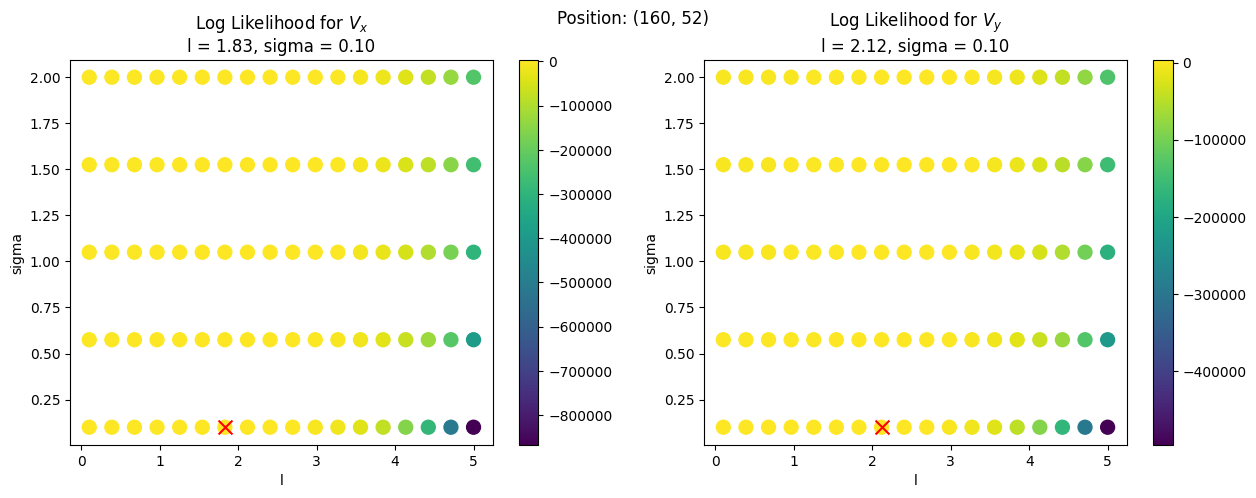

100%|██████████| 90/90 [00:10<00:00,  8.45it/s]


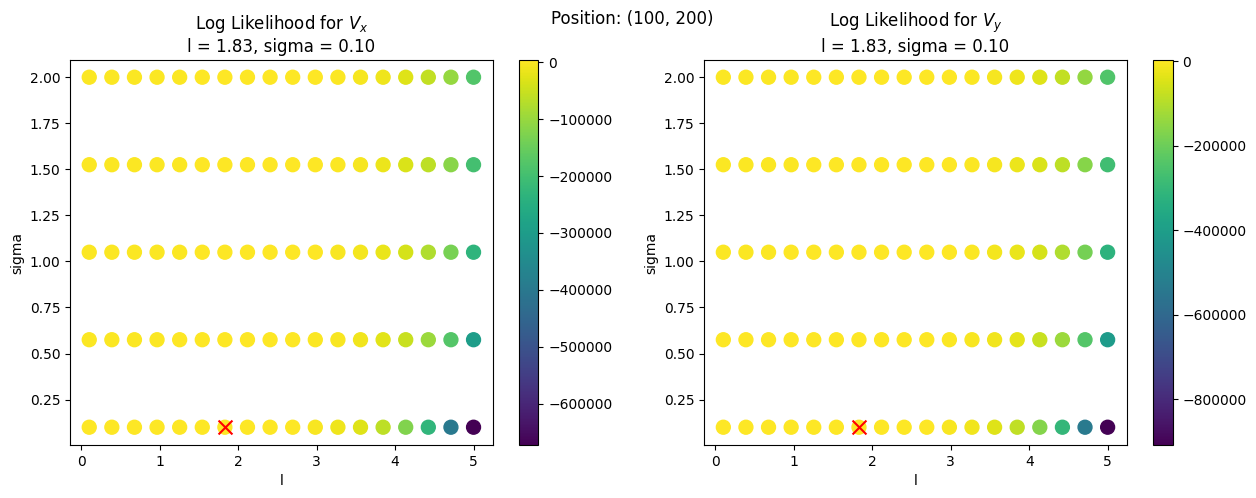

In [10]:
# ========== OPTIMIZING EACH POSITION ========== #

for position in positions:

    # Get the velocity data for the selected location
    x = position[0]
    y = position[1]
    V_pos = Vt[:, y, x, :]

    # Get the X and Y velocity components
    Vx_pos = V_pos[:, 0]
    Vy_pos = V_pos[:, 1]

    # Optimize the kernel parameters for the X component
    optimal_pos_params_x, x_results_df = optimize_kernel_params(
        data=Vx_pos,
        param_ranges=param_ranges,
        num_folds=num_folds,
        kernel=selected_kernel,
        mean_prediction_method=initial_mean_method
    )

    # Optimize the kernel parameters for the Y component
    optimal_pos_params_y, y_results_df = optimize_kernel_params(
        data=Vy_pos,
        param_ranges=param_ranges,
        num_folds=num_folds,
        kernel=selected_kernel,
        mean_prediction_method=initial_mean_method
    )

    # Plot the results of the grid search
    plot_grid_search_results(
        x_results_df=x_results_df,
        y_results_df=y_results_df,
        position=position,
        params_to_plot=plot_params,
        save_to_file=True,
        filename=f'{images_folder}{images_prefix}_grid_search_results_{position[0]}_{position[1]}.png'
    )


#### Problem 4.c (5 points)


100%|██████████| 90/90 [00:11<00:00,  7.98it/s]


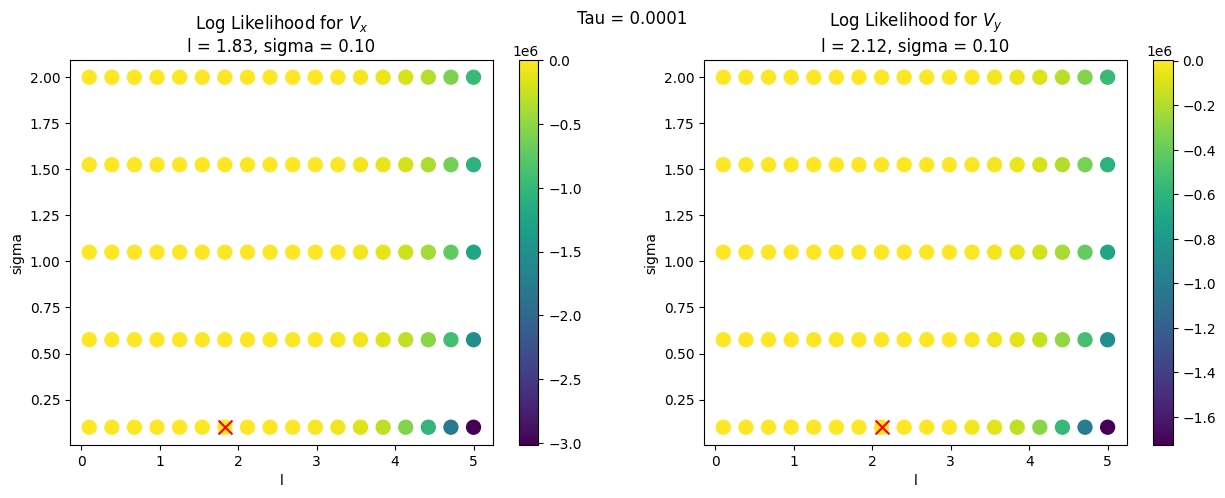

100%|██████████| 90/90 [00:10<00:00,  8.46it/s]


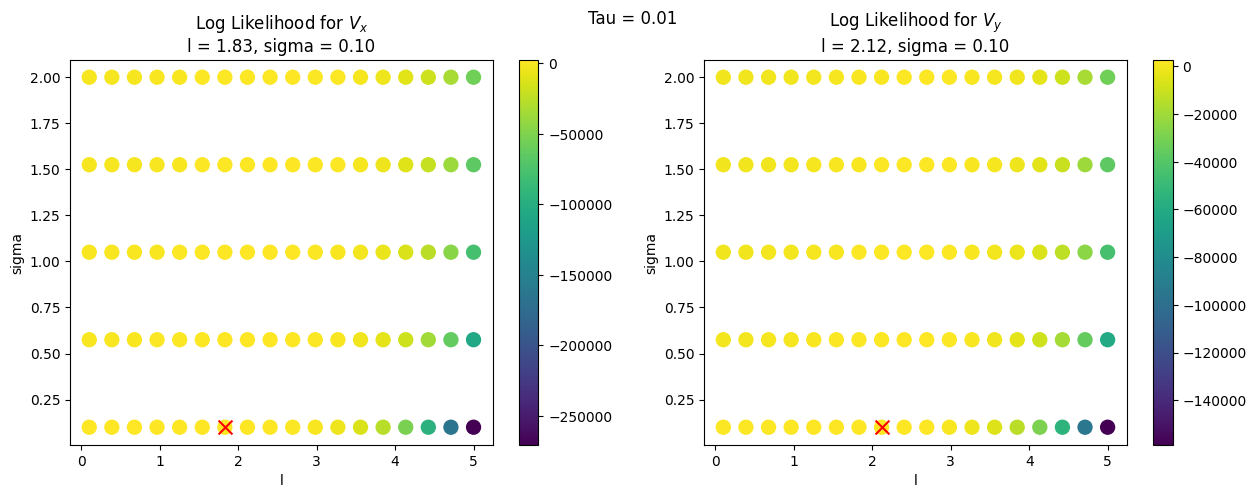

100%|██████████| 90/90 [00:10<00:00,  8.31it/s]


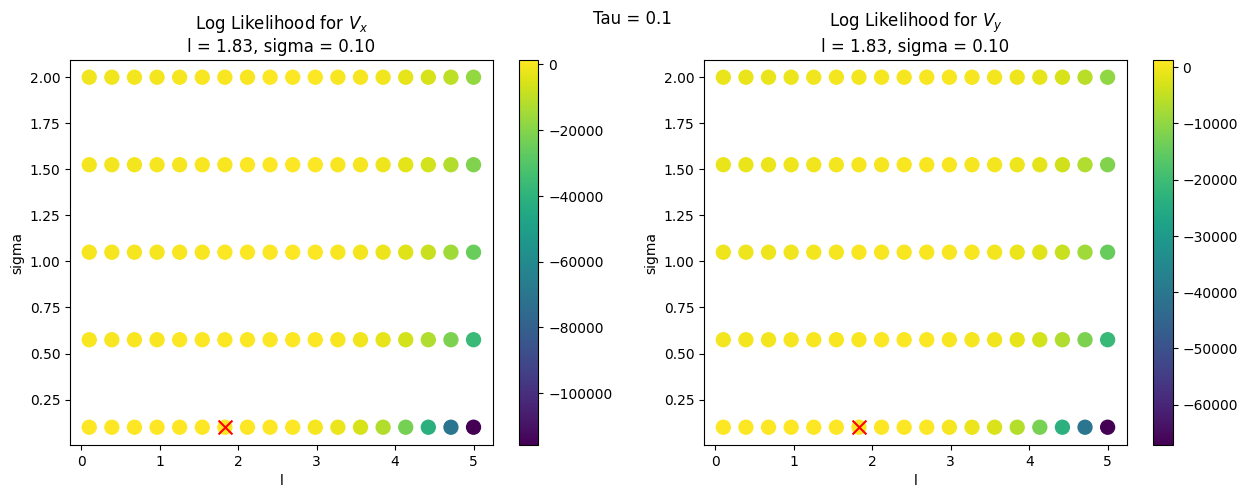

100%|██████████| 90/90 [00:10<00:00,  8.18it/s]


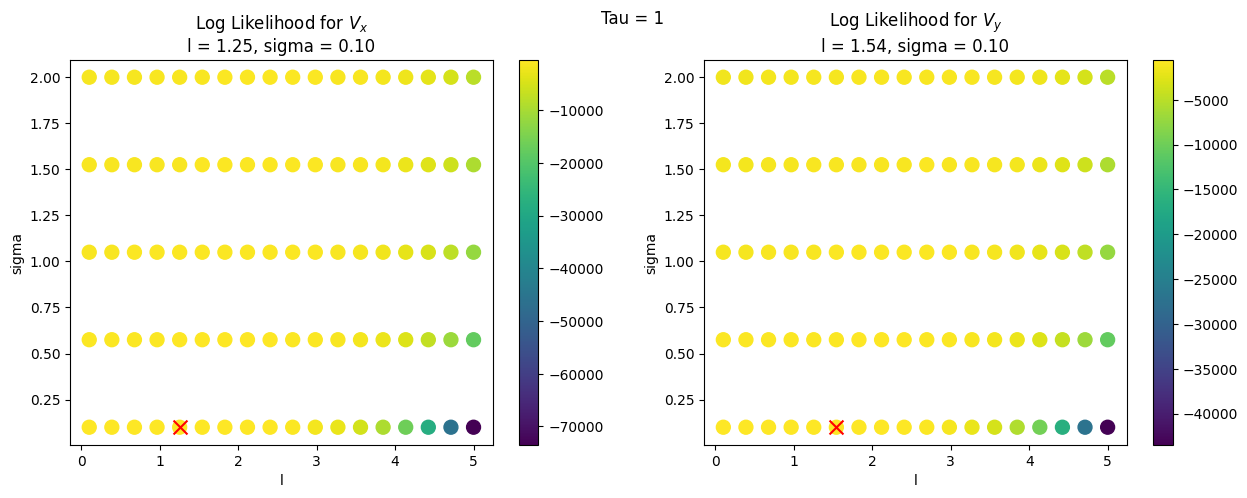

In [11]:
# Values of Tau to test
tau_values = [0.0001, 0.01, 0.1, 1]

for tau in tau_values:

    # Optimize the kernel parameters for the X component
    optimal_tau_params_x, x_results_df = optimize_kernel_params(
        data=Vx_loc,
        param_ranges=param_ranges,
        tau=tau,
        num_folds=num_folds,
        mean_prediction_method=initial_mean_method
    )

    # Optimize the kernel parameters for the Y component
    optimal_tau_params_y, y_results_df = optimize_kernel_params(
        data=Vy_loc,
        param_ranges=param_ranges,
        tau=tau,
        num_folds=num_folds,
        mean_prediction_method=initial_mean_method
    )

    # Plot the results of the grid search
    plot_grid_search_results(
        x_results_df=x_results_df,
        y_results_df=y_results_df,
        position=position,
        params_to_plot=plot_params,
        custom_title_text=f'Tau = {tau}',
        save_to_file=True,
        filename=f'{images_folder}{images_prefix}_grid_search_results_tau_{tau}.png'
    )


#### Problem 4.d (10 points)


In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

# Get the "Xs" and "Ys" for the Gaussian Process
y_x = Vx_loc
y_y = Vy_loc
X = np.arange(0, len(y_x)).reshape(-1, 1)

# Split the data into training and testing sets
# (There's no need for re-defining X because it's the same for both components)
X_train, X_test, y_x_train, y_x_test = train_test_split(
    X, y_x, test_size=0.2, random_state=42
)
_, _, y_y_train, y_y_test = train_test_split(
    X, y_y, test_size=0.2, random_state=42
)

# Fit the Gaussian Process to the training data
gpr_fit = GaussianProcessRegressor(kernel=RBF()).fit(X_train, y_x_train)
params_x = gpr_fit.kernel_.get_params()
score_x = gpr_fit.score(X_test, y_x_test)
print("X - Kernel parameters: ", params_x)
print("X - Score: ", score_x)

gpr_fit = GaussianProcessRegressor(kernel=RBF()).fit(X_train, y_y_train)
params_y = gpr_fit.kernel_.get_params()
score_y = gpr_fit.score(X_test, y_y_test)
print("Y - Kernel parameters: ", params_y)
print("Y - Score: ", score_y)


X - Kernel parameters:  {'length_scale': 1.747079835442446, 'length_scale_bounds': (1e-05, 100000.0)}
X - Score:  0.8543166810747069
Y - Kernel parameters:  {'length_scale': 1.9011429770930213, 'length_scale_bounds': (1e-05, 100000.0)}
Y - Score:  0.8882170657557578


#### Problem 5 (15 points)


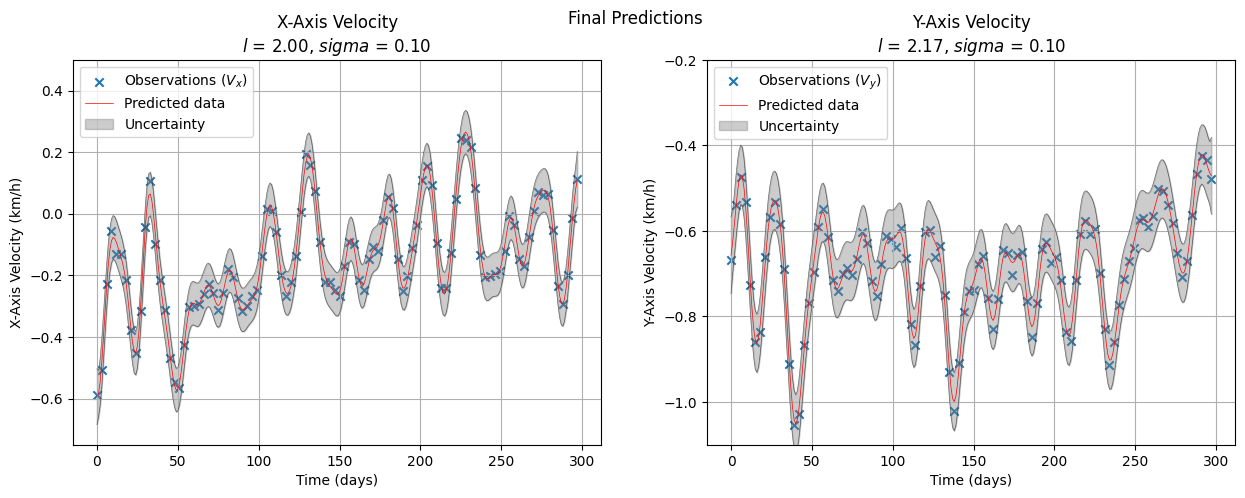

In [7]:
# Get the full range of values for X
# (For the Philippines dataset, this is just the X axis of the data, or
# a range from 0 to the number of timesteps)
X = np.arange(Vx_loc.shape[0])

# Currently we have measurements for every 3 days. We previously assumed that
# ocean currents remain constant for about 3 hours, therefore, we can predict
# the velocity at smaller time intervals by having 24 measurements in between
# each of the original measurements (i.e. 24 * 3 = 72 hours = 3 days).
X_pred = add_intermediate_points(X, 2)

# ================= PREDICTIONS ================ #

# Turn the optimal parameters into a tuple
optimal_params_vx = tuple(optimal_params_x.values())
optimal_params_vy = tuple(optimal_params_y.values())

# Calculate the conditional mean and variance of the X component
conditional_mean_x, conditional_variance_x, _ = predict_conditional_mean_and_var(
    x1=X_pred,
    x2=X,
    y2=Vx_loc,
    kernel=selected_kernel,
    kernel_args=optimal_params_vx,
    mean_prediction_method=initial_mean_method
)

# Calculate the conditional mean and variance of the Y component
conditional_mean_y, conditional_variance_y, _ = predict_conditional_mean_and_var(
    x1=X_pred,
    x2=X,
    y2=Vy_loc,
    kernel=selected_kernel,
    kernel_args=optimal_params_vy,
    mean_prediction_method=initial_mean_method
)

# Extract the variance along the diagonal
var_x = np.sqrt(np.diagonal(conditional_variance_x))
var_y = np.sqrt(np.diagonal(conditional_variance_y))

# ============== PLOT X COMPONENT ============== #

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Convert the "X" values to days by multiplying by 3
t_days = X * 3

# Convert the "X_pred" values to days by multiplying by 3
t_pred_days = X_pred * 3

# Plot the results
ax1.scatter(
    t_days,
    Vx_loc,
    label='Observations ($V_x$)',
    marker='x',
)
ax1.plot(
    t_pred_days,
    conditional_mean_x,
    label='Predicted data',
    color='red',
    linewidth=0.5
)
ax1.plot(
    t_pred_days,
    conditional_mean_x + 3*var_x,
    color="black",
    linewidth=0.5,
    alpha=0.5
)
ax1.plot(
    t_pred_days,
    conditional_mean_x - 3*var_x,
    color="black",
    linewidth=0.5,
    alpha=0.5
)
ax1.fill_between(
    t_pred_days,
    conditional_mean_x + 3*var_x,
    conditional_mean_x - 3*var_x,
    label="Uncertainty",
    color="gray",
    alpha=0.4
)

# Build the title string for the X component
vx_title = f"X-Axis Velocity\n"

# For each optimal parameter, add it to the title string
for key, value in optimal_params_x.items():
    vx_title += f"${key}$ = {value:.2f}, "

# Remove the trailing comma and space
vx_title = vx_title[:-2]

ax1.legend()
ax1.grid()
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('X-Axis Velocity (km/h)')
ax1.set_title(vx_title)

# ============== PLOT Y COMPONENT ============== #

ax2.scatter(
    t_days,
    Vy_loc,
    label='Observations ($V_y$)',
    marker='x',
)
ax2.plot(
    t_pred_days,
    conditional_mean_y,
    label='Predicted data',
    color='red',
    linewidth=0.5
)
ax2.plot(
    t_pred_days,
    conditional_mean_y + 3*var_y,
    color="black",
    linewidth=0.5,
    alpha=0.5
)
ax2.plot(
    t_pred_days,
    conditional_mean_y - 3*var_y,
    color="black",
    linewidth=0.5,
    alpha=0.5
)
ax2.fill_between(
    t_pred_days,
    conditional_mean_y + 3*var_y,
    conditional_mean_y - 3*var_y,
    label="Uncertainty",
    color="gray",
    alpha=0.4
)

ax2.legend()
ax2.grid()
ax2.set_xlabel(
    'Time (days)'
)
ax2.set_ylabel(
    'Y-Axis Velocity (km/h)'
)

# Build the title string for the Y component
vy_title = f"Y-Axis Velocity\n"

# For each optimal parameter, add it to the title string
for key, value in optimal_params_y.items():
    vy_title += f"${key}$ = {value:.2f}, "

# Remove the trailing comma and space
vy_title = vy_title[:-2]
ax2.set_title(vy_title)

# Set max value of Y for the X component
ax1.set_ylim([-0.75, 0.5])

# Set max value of Y for the Y component
ax2.set_ylim([-1.1, -0.2])

# Super title with the parameters used
fig.suptitle("Final Predictions")

# Save the figure
plt.savefig(f"{images_folder}{images_prefix}_final_predictions.png")

plt.show()


#### Problem 6.a (15 points)

Generating predictions for the entire set of coordinates. Took almost 2 hours to run.


In [ ]:
# ============================================== #
# BUILDING NEW VELOCITY MATRIX                   #
# ============================================== #

# Make two arrays, one for all the possible X coordinates
# and one for all the possible Y coordinates
x_coords = np.arange(Vt.shape[2])
y_coords = np.arange(Vt.shape[1])
print("X Coords:", x_coords.shape)
print("Y Coords:", y_coords.shape)

# Create a meshgrid from the X and Y coordinates
*coordinates, = np.meshgrid(x_coords, y_coords)

# Flatten the meshgrid into a 1D array of coordinate pairs
flattened_coordinates = []
for coords in coordinates:
    flattened_coordinates.append(coords.flatten())

# Build an N,2 array of all the possible coordinates in the grid
coordinate_pairs = np.array(flattened_coordinates).T

# Get the new number of timesteps
new_timesteps = X_pred.shape[0]

# ================= PREDICTIONS ================ #

# Create a new array with the following shape:
# (new_timesteps, y_coords, x_coords, 2)
Vt_pred = np.zeros((new_timesteps, y_coords.shape[0], x_coords.shape[0], 2))

for idx, pair in enumerate(tqdm(coordinate_pairs)):

    x = pair[0]
    y = pair[1]

    # Fetch the velocity at all times for the given coordinate pair
    v_pos = Vt[:, y, x, :]

    # Get the X and Y components of the velocity
    vx_pos = v_pos[:, 0]
    vy_pos = v_pos[:, 1]

    # Calculate the conditional mean and variance of the X component
    conditional_mean_x, _, _ = predict_conditional_mean_and_var(
        x1=X_pred,
        x2=X,
        y2=vx_pos,
        kernel=selected_kernel,
        kernel_args=optimal_params_vx,
        mean_prediction_method=initial_mean_method
    )

    # Calculate the conditional mean and variance of the X component
    conditional_mean_y, _, _ = predict_conditional_mean_and_var(
        x1=X_pred,
        x2=X,
        y2=vy_pos,
        kernel=selected_kernel,
        kernel_args=optimal_params_vy,
        mean_prediction_method=initial_mean_method
    )

    # Add the X and Y components of the velocity to the new array
    Vt_pred[:, y, x, 0] = conditional_mean_x
    Vt_pred[:, y, x, 1] = conditional_mean_y


Loading or saving the $Vt_{pred}$ data


In [5]:
# Check if the Vt_pred variable exists
if "Vt_pred" in locals():
    key_pressed = input(
        "Press 'y' to overwrite the variable, or any other key to exit: "
    )
    if key_pressed != "y":
        pass
    else:
        np.save(f"./data/Vt_pred.npy", Vt_pred)
else:
    Vt_pred = np.load(f"./data/Vt_pred.npy")

Flow simulation with the $Vt_{pred}$ data


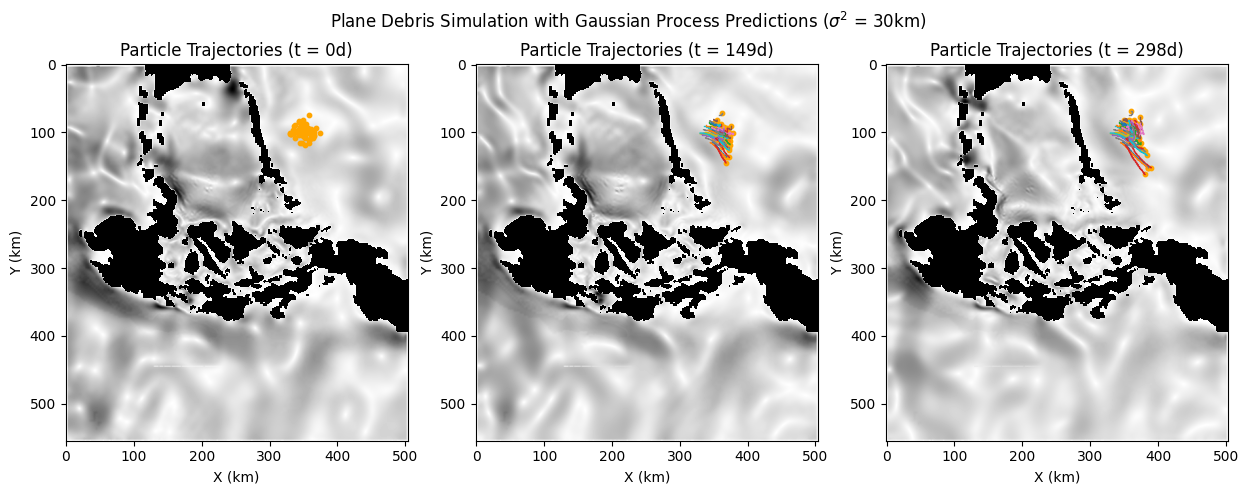

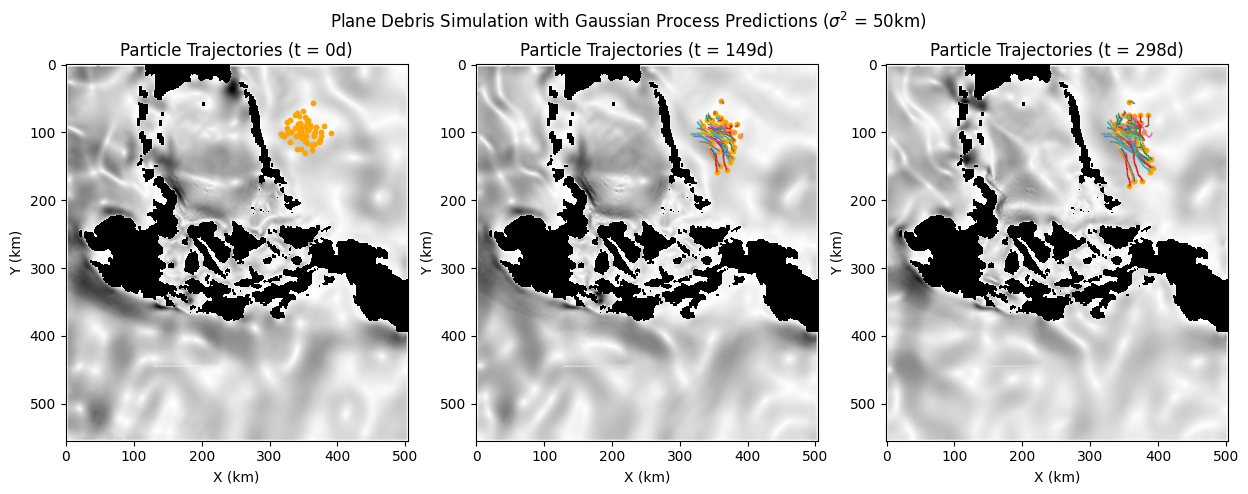

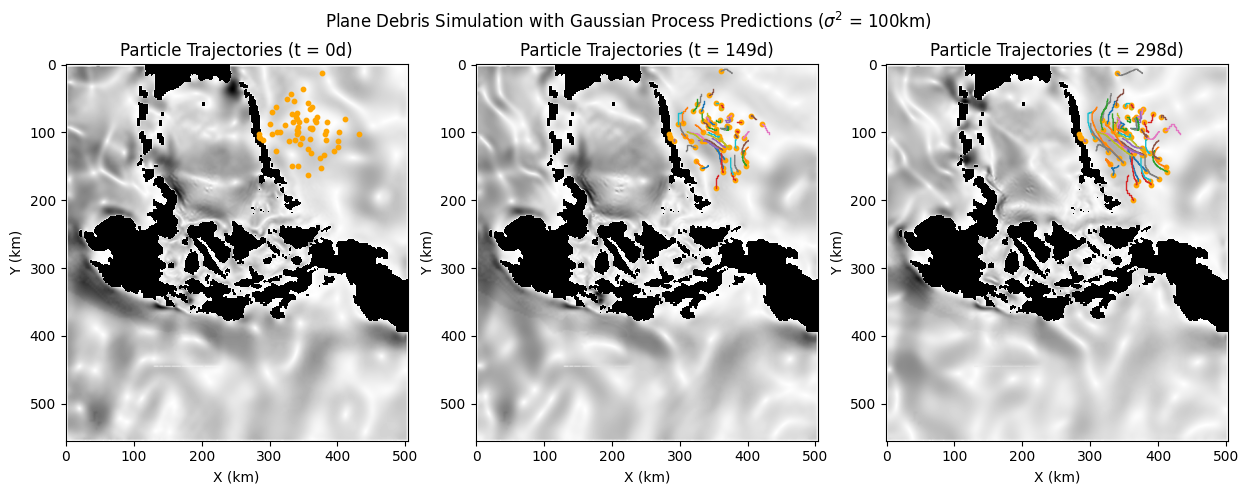

In [6]:
# ============================================== #
# SIMULATION                                     #
# ============================================== #

# Number of crash locations to simulate
N = 60

# Number of timesteps to simulate
T = Vt_pred.shape[0]

# Mean of the place where the plane crashed
# (Given in indexes. Multiply by 3 to get kilometers)
mu_crash = np.array([[100, 350]])

# Variances to test for the crash location
# (In kilometers)
variances_crash_km = [30, 50, 100]

# ============== INITIAL POSITIONS ============= #

for sigma_km in variances_crash_km:

    # Convert the variance to indexes
    sigma_crash = sigma_km / 3

    # Generate random crash locations from a normal distribution
    np.random.seed(42)
    crash_locations = np.random.normal(
        loc=mu_crash,
        scale=sigma_crash,
        size=(N, 2)
    )

    # Remove crash locations that start with a

    # Simulate the flow for the crash locations
    X_history, V_history = simulate_flow(
        x_t=crash_locations,
        v_t=Vt_pred,
        timesteps=T,
        epsilon=1,
    )

    # ==================== PLOT ==================== #

    # Plot with 1 row and 3 columns
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the trajectories of the particles
    plot_particle_simulation(
        X_history,
        V_history,
        v_t=Vt_pred,
        land_mask=mask,
        end_timestep=0,
        adjust_time=False,
        custom_ax=axs[0],
        quivers=False
    )
    plot_particle_simulation(
        X_history,
        V_history,
        v_t=Vt_pred,
        land_mask=mask,
        end_timestep=int(T*0.5),
        adjust_time=False,
        custom_ax=axs[1],
        quivers=False
    )
    plot_particle_simulation(
        X_history,
        V_history,
        v_t=Vt_pred,
        land_mask=mask,
        end_timestep=int(T*1),
        adjust_time=False,
        custom_ax=axs[2],
        quivers=False
    )

    # Set the title for the figure
    fig.suptitle(
        f"Plane Debris Simulation with Gaussian Process Predictions ($\sigma^2$ = {sigma_km}km)"
    )

    # Save the figure
    fig.savefig(
        f"{images_folder}{images_prefix}_plane_debris_sigma_{sigma_km}.png")
    plt.show()

#### Problem 6.b (14 points)


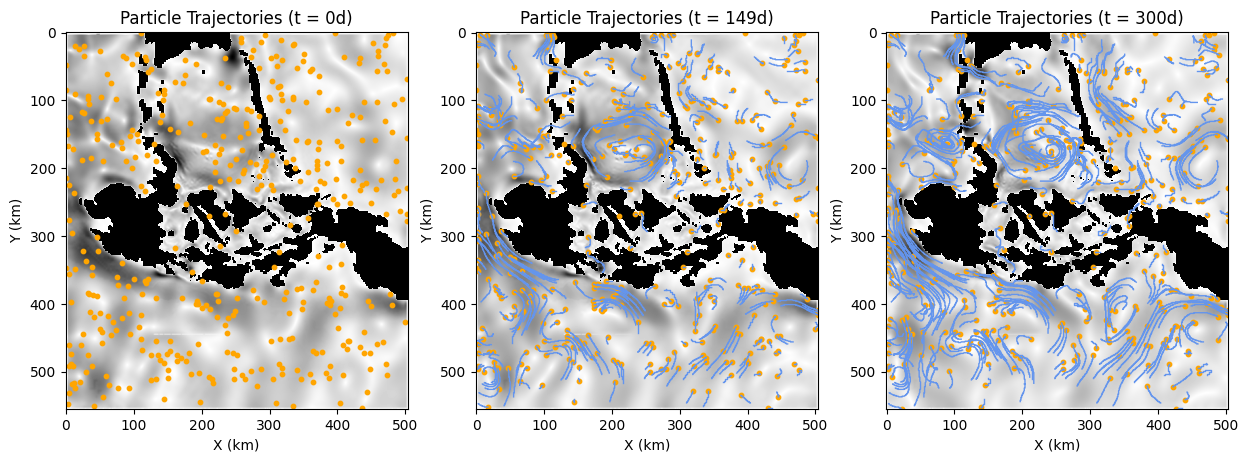

In [24]:
# ============== INITIAL POSITIONS ============= #

# Number of particles to simulate
N = 500

# Get the max and min X and Y coordinates
Xaxis_min = 0
Xaxis_max = Vt_pred.shape[2]
Yaxis_min = 0
Yaxis_max = Vt_pred.shape[1]

# Generate random X and Y coordinates for the particles
np.random.seed(42)
particles_x_pos = np.random.randint(Xaxis_min, Xaxis_max, size=N)
particles_y_pos = np.random.randint(Yaxis_min, Yaxis_max, size=N)

# Concatenate the X and Y coordinates as columns in a single array
x_particles = np.stack(
    [particles_x_pos, particles_y_pos],
    axis=1
)

# Remove particles that start on land
x_particles_masked = x_particles[
    mask[particles_y_pos, particles_x_pos] == 1
]

# ================= SIMULATION ================= #

X_history, V_history = simulate_flow(
    x_t=x_particles_masked,
    v_t=Vt_pred,
    timesteps=T,
    epsilon=1
)

# ==================== PLOT ==================== #

# Plot with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the trajectories of the particles
plot_particle_simulation(
    X_history,
    V_history,
    v_t=Vt_pred,
    land_mask=mask,
    end_timestep=int(T*0),
    adjust_time=False,
    quivers=False,
    trajectory_color="cornflowerblue",
    custom_ax=axs[0]
)
plot_particle_simulation(
    X_history,
    V_history,
    v_t=Vt_pred,
    land_mask=mask,
    end_timestep=int(T*0.5),
    adjust_time=False,
    quivers=False,
    trajectory_color="cornflowerblue",
    custom_ax=axs[1]
)
plot_particle_simulation(
    X_history,
    V_history,
    v_t=Vt_pred,
    land_mask=mask,
    end_timestep=int(T),
    adjust_time=False,
    quivers=False,
    trajectory_color="cornflowerblue",
    custom_ax=axs[2],
    custom_title="Particle Trajectories (t = 300d)"
)

fig.savefig(f"{images_folder}{images_prefix}_stranded_simulation.png")
plt.show()

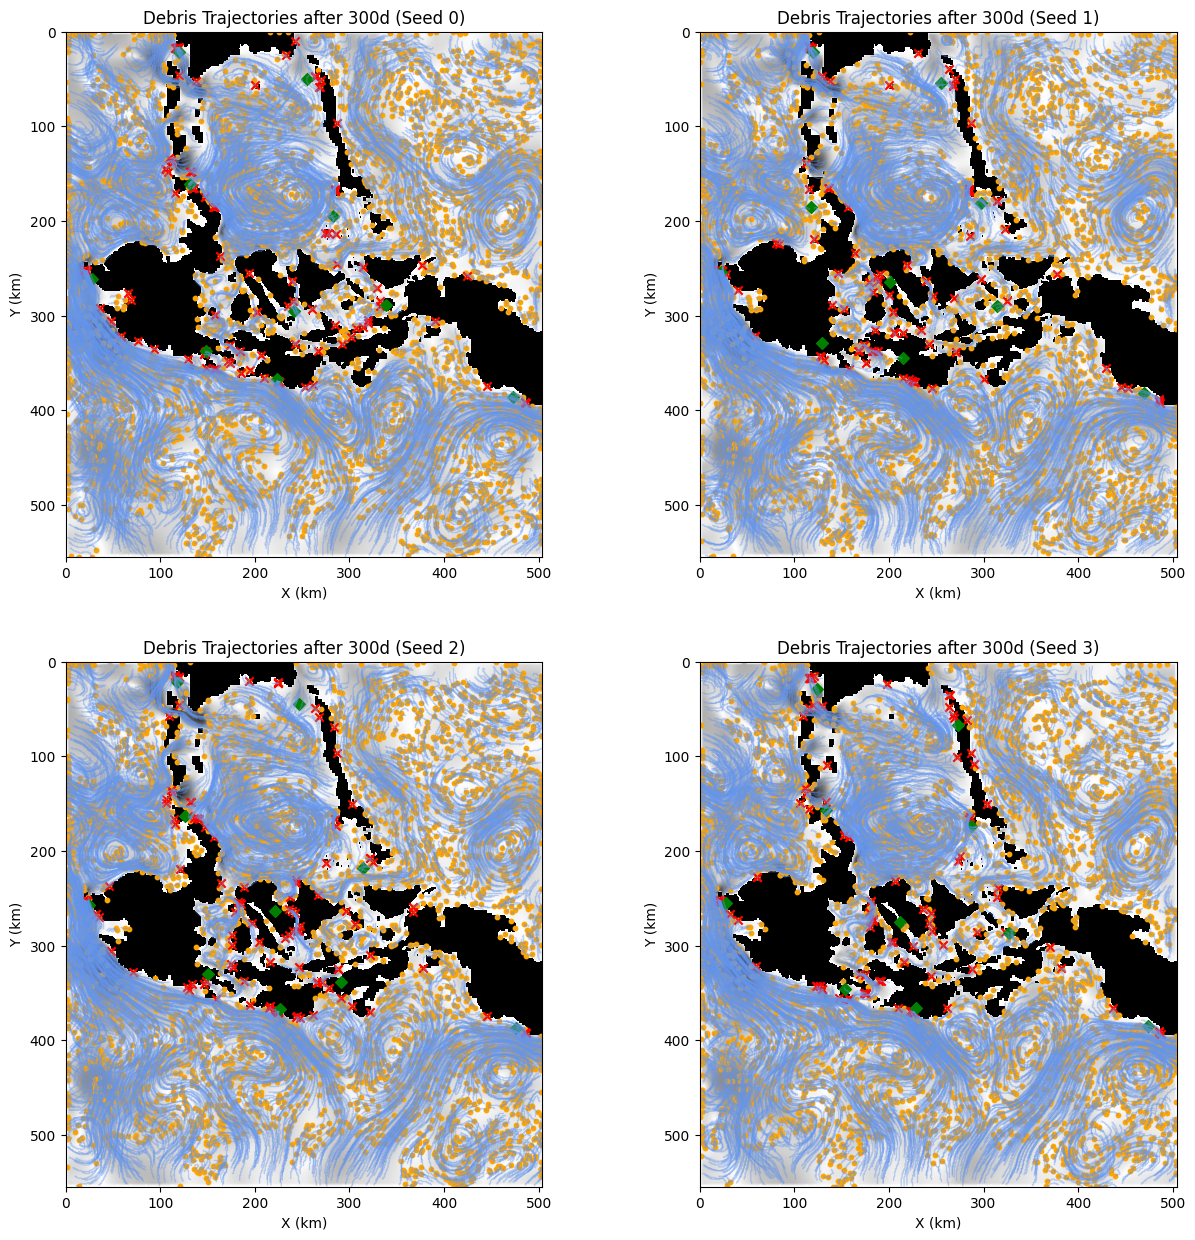

In [16]:
# ============================================== #
# SIMULATION                                     #
# ============================================== #

# Number of particles to simulate
N = 5000

# Number of timesteps to simulate
T = Vt_pred.shape[0]

# Try different seeds to generate different initial positions
test_seeds = [30, 420, 69, 42069]

# Create a 4 subplots, 2 rows and 2 columns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

for idx, seed in enumerate(test_seeds):

    if idx == 0:
        ax = ax1
    elif idx == 1:
        ax = ax2
    elif idx == 2:
        ax = ax3
    else:
        ax = ax4

    # ============== INITIAL POSITIONS ============= #

    # Get the max and min X and Y coordinates
    Xaxis_min = 0
    Xaxis_max = Vt_pred.shape[2]
    Yaxis_min = 0
    Yaxis_max = Vt_pred.shape[1]

    # Generate random X and Y coordinates for the particles
    np.random.seed(seed)
    particles_x_pos = np.random.randint(Xaxis_min, Xaxis_max, size=N)
    particles_y_pos = np.random.randint(Yaxis_min, Yaxis_max, size=N)

    # Concatenate the X and Y coordinates as columns in a single array
    x_particles = np.stack(
        [particles_x_pos, particles_y_pos],
        axis=1
    )

    # Remove particles that start on land
    x_particles_masked = x_particles[
        mask[particles_y_pos, particles_x_pos] == 1
    ]

    # ================= SIMULATION ================= #

    X_history, V_history = simulate_flow(
        x_t=x_particles_masked,
        v_t=Vt_pred,
        timesteps=T,
        epsilon=1
    )

    # ==================== PLOT ==================== #

    # Plot the trajectories of the particles
    plot_particle_simulation(
        X_history,
        V_history,
        v_t=Vt_pred,
        land_mask=mask,
        end_timestep=T,
        adjust_time=False,
        custom_ax=ax,
        quivers=False,
        trajectory_color="cornflowerblue",
        trajectory_alpha=0.4,
        custom_title=f"Debris Trajectories after 300d (Seed {idx})"
    )

    # ============= STRANDED PARTICLES ============= #

    # Calculate the speed in the last timestep
    final_speed = np.sqrt(V_history[-1, :, 0]**2 + V_history[-1, :, 1]**2)

    # Get the indexes where the debris got stranded on land (speed = 0)
    stranded_indexes = np.where(final_speed == 0)[0]

    # Get the final positions of the stranded debris
    stranded_positions = X_history[-1, stranded_indexes, :]

    # Clip the stranded positions to be within the map
    stranded_positions = np.clip(
        stranded_positions,
        a_min=[0, 0],
        a_max=[Xaxis_max-1, Yaxis_max-1]
    )

    # Filter the stranded positions to only include those that are on land
    # (Technically the borders of the map dont have speed, but we will ignore that)
    stranded_positions = stranded_positions[mask[
        stranded_positions[:, 1],
        stranded_positions[:, 0]
    ] == 0]

    # Extract the X and Y coordinates of the stranded debris
    stranded_positions_x = stranded_positions[:, 1]
    stranded_positions_y = stranded_positions[:, 0]

    # Plot the final positions of the stranded debris
    ax.scatter(
        stranded_positions_x,
        stranded_positions_y,
        color='red',
        marker='x',
        label='Stranded Debris'
    )

    # =================== KMEANS =================== #

    # Number of clusters to use
    K = 10

    if stranded_positions.shape[0] >= K:

        # Fit a KMeans model to find possible locations for outposts
        kmeans = KMeans(n_clusters=K, n_init='auto')
        kmeans_fit = kmeans.fit(stranded_positions)

        # Get the cluster centers
        cluster_centers = kmeans_fit.cluster_centers_

        # Get the X and Y coordinates of the cluster centers
        cluster_centers_x = cluster_centers[:, 1]
        cluster_centers_y = cluster_centers[:, 0]

        # Plot the cluster centers
        ax.scatter(
            cluster_centers_x,
            cluster_centers_y,
            color='green',
            marker='D',
            label='Cluster Centers'
        )

    # ================= PLOT LIMITS ================ #

    # Set the limits of the plot
    ax.set_ylim([Xaxis_max, Xaxis_min])
    ax.set_xlim([Yaxis_min, Yaxis_max])

# Save the figure
plt.savefig(f"{images_folder}{images_prefix}_particles_simulation.png")
plt.show()


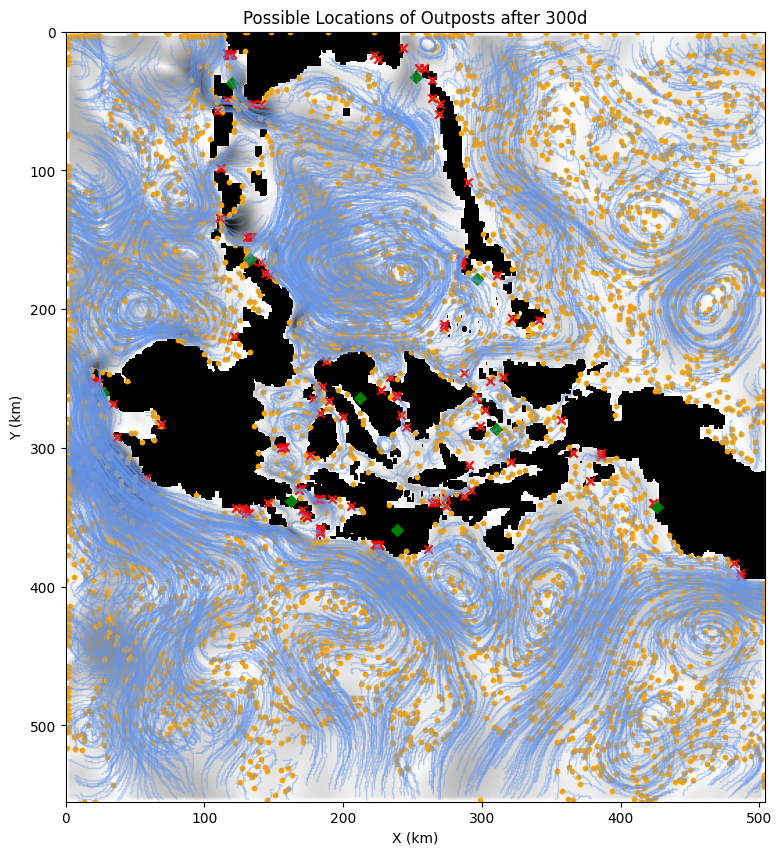

In [30]:
# ============== INITIAL POSITIONS ============= #

# Number of particles to simulate
N = 6000

# Get the max and min X and Y coordinates
Xaxis_min = 0
Xaxis_max = Vt_pred.shape[2]
Yaxis_min = 0
Yaxis_max = Vt_pred.shape[1]

# Generate random X and Y coordinates for the particles
np.random.seed(42)
particles_x_pos = np.random.randint(Xaxis_min, Xaxis_max, size=N)
particles_y_pos = np.random.randint(Yaxis_min, Yaxis_max, size=N)

# Concatenate the X and Y coordinates as columns in a single array
x_particles = np.stack(
    [particles_x_pos, particles_y_pos],
    axis=1
)

# Remove particles that start on land
x_particles_masked = x_particles[
    mask[particles_y_pos, particles_x_pos] == 1
]

# ================= SIMULATION ================= #

X_history, V_history = simulate_flow(
    x_t=x_particles_masked,
    v_t=Vt_pred,
    timesteps=T,
    epsilon=1
)

# ==================== PLOT ==================== #

# Create a plot with a single subplot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the trajectories of the particles
plot_particle_simulation(
    X_history,
    V_history,
    v_t=Vt_pred,
    land_mask=mask,
    end_timestep=T,
    adjust_time=False,
    quivers=False,
    trajectory_color="cornflowerblue",
    trajectory_alpha=0.4,
    custom_title=f"Possible Locations of Outposts after 300d",
    custom_ax=ax
)

# ============= STRANDED PARTICLES ============= #

# Calculate the speed in the last timestep
final_speed = np.sqrt(V_history[-1, :, 0]**2 + V_history[-1, :, 1]**2)

# Get the indexes where the debris got stranded on land (speed = 0)
stranded_indexes = np.where(final_speed == 0)[0]

# Get the final positions of the stranded debris
stranded_positions = X_history[-1, stranded_indexes, :]

# Clip the stranded positions to be within the map
stranded_positions = np.clip(
    stranded_positions,
    a_min=[0, 0],
    a_max=[Xaxis_max-1, Yaxis_max-1]
)

# Filter the stranded positions to only include those that are on land
# (Technically the borders of the map dont have speed, but we will ignore that)
stranded_positions = stranded_positions[mask[
    stranded_positions[:, 1],
    stranded_positions[:, 0]
] == 0]

# Extract the X and Y coordinates of the stranded debris
stranded_positions_x = stranded_positions[:, 1]
stranded_positions_y = stranded_positions[:, 0]

# Plot the final positions of the stranded debris
ax.scatter(
    stranded_positions_x,
    stranded_positions_y,
    color='red',
    marker='x',
    label='Stranded Debris'
)

# =================== KMEANS =================== #

# Number of clusters to use
K = 10

if stranded_positions.shape[0] >= K:

    # Fit a KMeans model to find possible locations for outposts
    kmeans = KMeans(n_clusters=K, n_init='auto')
    kmeans_fit = kmeans.fit(stranded_positions)

    # Get the cluster centers
    cluster_centers = kmeans_fit.cluster_centers_

    # Get the X and Y coordinates of the cluster centers
    cluster_centers_x = cluster_centers[:, 1]
    cluster_centers_y = cluster_centers[:, 0]

    # Plot the cluster centers
    ax.scatter(
        cluster_centers_x,
        cluster_centers_y,
        color='green',
        marker='D',
        label='Cluster Centers'
    )

# ================= PLOT LIMITS ================ #

# Set the limits of the plot
ax.set_ylim([Xaxis_max, Xaxis_min])
ax.set_xlim([Yaxis_min, Yaxis_max])

fig.savefig(f"{images_folder}{images_prefix}_possible_outposts.png")
plt.show()